<a href="https://colab.research.google.com/github/DeemOne-personal/Python-lessons/blob/main/homework_2_poetry_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#with open('/content/drive/MyDrive/Colab Notebooks/Edu4 - DS MFTI Adv/Files/HW2/onegin.txt', 'r') as iofile:  
with open('/content/drive/MyDrive/Colab Notebooks/Edu4 - DS MFTI Adv/Files/HW2/sonnets.txt', 'r') as iofile:
    source_text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = source_text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
import string 
# Join all the strings into one and lowercase it
# Put result into variable text.
#res=''.join([line.rstrip('\n') for line in text]).replace(',','').replace('  ', ' ').lstrip()
text=''.join(line for line in text).lower()

# Your great code here
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [4]:
#put all characters to variable tokens 
tokens = sorted(set(text))
num_tokens = len(tokens)
print('num tokens: '+str(num_tokens))

# dict <index>:<char>
# Your great code here
idx_to_token={k:v for k, v in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
#token_to_idx={v:k for k, v in enumerate(tokens)}
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

#check the size
assert num_tokens == len(idx_to_token), "dictionaries must have same size"
assert num_tokens == len(token_to_idx), "dictionaries must have same size"

#check positional assignments of two arrays
for n in range(len(tokens)):
  assert token_to_idx[idx_to_token[n]]==n, 'positional assign of two arrays must be the same'

#setting max length variable
#MAX_LENGTH=max(map(len,str(text).split('\n')))

num tokens: 38


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

In [ ]:
#text

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [8]:
import numpy as np
def to_matrix(names, max_len=None, pad=token_to_idx[" "], dtype="int32", batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""

    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_idx[c] for c in names[i]]
        names_ix[i, : len(line_ix)] = line_ix

    if not batch_first:  # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [6]:
#matrix conversion result:
ttt=text[0:23]
#print(tttmatrix)
textmatrix=to_matrix(ttt)
textmatrix

array([[ 1],
       [ 1],
       [17],
       [29],
       [26],
       [24],
       [ 1],
       [17],
       [12],
       [20],
       [29],
       [16],
       [30],
       [31],
       [ 1],
       [14],
       [29],
       [16],
       [12],
       [31],
       [32],
       [29],
       [16]], dtype=int32)

tensor([[15, 16, 25,  1,  1],
        [21, 19, 26, 25,  1]])


In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
emb_test = nn.Embedding(55, 7) # One hot + Linears


In [ ]:
#convert to tensor sample
example_batch = torch.from_numpy(to_matrix(['den ', 'jhon '])).type(torch.int64)
print('***Convert to tensor sample:')
print(example_batch.shape)
print(example_batch)

print('***Embedding with parameters sample:')
example_batch = torch.from_numpy(to_matrix(['den ', 'jhon '])).type(torch.int64)
emb = emb_test(example_batch)
print(emb.shape)
emb

In [97]:
from torch import nn
import torch
import torch.nn.functional as F
from random import sample

In [96]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.num_units = rnn_num_units

    def forward(self, x):
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [98]:
#added by me
#char_rnn = CharRNNCell()
char_rnn = CharRNNLoop() #replace CharRNNCell 
criterion = nn.NLLLoss() 

In [99]:
MAX_LENGTH=max(map(len,str(text).split('\n')))

model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

# the model applies over the whole sequence
batch_ix = to_matrix(sample(text, 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

In [100]:
logp_seq = model(batch_ix)

loss = criterion(
    logp_seq[:, :-1].contiguous().view(-1, num_tokens), batch_ix[:, 1:].contiguous().view(-1)
)

loss.backward()

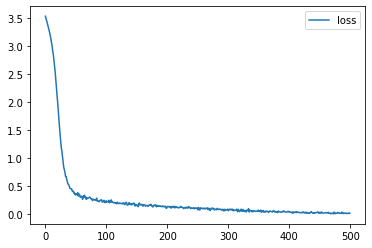

In [101]:
#added by me
from IPython.display import clear_output
import matplotlib.pyplot as plt
#/added by me

MAX_LENGTH = 16

for i in range(500):
    batch_ix = to_matrix(sample(text, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = model(batch_ix)

    predictions_logp = logp_seq[:, :-1]  # YOUR CODE HERE
    actual_next_tokens = batch_ix[:, 1:]  # YOUR CODE HERE

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens), actual_next_tokens.contiguous().view(-1)
    )
    # YOUR CODE HERE

    # train with backprop
    # YOUR CODE HERE
    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [104]:
#!!!!!!!!!ОШИБКА ЗДЕСЬ
#sample generation
def generate_sample(char_rnn, seed_phrase=" ", max_length=MAX_LENGTH, temperature=1.0):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    # feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        #hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
        hid_state, _ = char_rnn(x_sequence[:, i])

    # start generating
    for _ in range(max_length - len(seed_phrase)):
        #hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)      
        hid_state, logits = char_rnn(x_sequence[:, -1])      
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return "".join([tokens[ix] for ix in x_sequence.data.numpy()[0]])


for _ in range(10):
    print(generate_sample(model, seed_phrase='hello', temperature=1.0))

RuntimeError: ignored



---



Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [ ]:
# Your plot code here

In [ ]:
# An example of generated text. There is no function `generate_text` in the code above.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
# Your beautiful code here

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)